In [1]:
import networkx as nx
from networkx.generators.random_graphs import _random_subset
import sympy as sp
from sympy import symbols 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify


import copy
import time
import random as rd

In [2]:
G = nx.read_adjlist("BA.adjlist")

In [3]:
N = len(G.nodes)

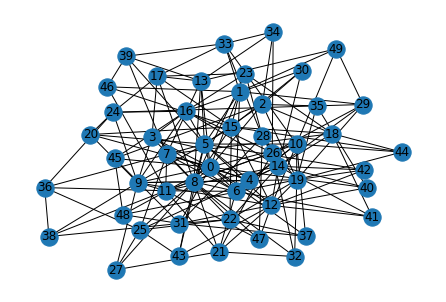

In [4]:
nx.draw(G, with_labels=True)    
plt.show()

In [5]:
adjacency = list(G.adjacency())

In [6]:
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)]

for a, b in adjacency :
    a = int(a)
    for c in b :
        c = int(c)
        A[a][c] = 1

In [7]:
index = []
for i in range(N):
    for j in range(i+1, N):
        if A[i][j] == 1:
            index += [(i,j)]

removed_link = index[rd.randint(0, len(index)-1)]
links = len(index) - 1

In [8]:
print("It was removed the link between node", removed_link[0], "and node", removed_link[1])

It was removed the link between node 18 and node 23


In [9]:
A[removed_link[0]][removed_link[1]] = 0
A[removed_link[1]][removed_link[0]] = 0

In [10]:
W = symbols(f'w:{links}')
print("There are", links, "indipendent weights")

There are 183 indipendent weights


In [11]:
count = 0
P = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P[i][j] == 1:
            P[i][j] = W[count]
            P[j][i] = W[count]
            count += 1

2* L'autovettore stazionario non coincide

In [12]:
with open("BA-pS.txt", "r") as file:
    pS = file.read()
    pS = pS.split("\n")
pS = [float(i) for i in pS]
pS = np.round(pS, 5)

In [13]:
e = (np.dot(pS, P) - pS)**2
E = e[0]
for i in range(1, len(e)):
    E += e[i]

1* Aggiungere la normalizzazione dei pesi alla funzione di costo fa ottenere molti autovettori vicini a 1 e l'autovettore stazionario non coincide con il valore atteso.

In [14]:
t0 = time.time()

my_func = lambdify(W, E)

def my_func_v(x):
    return my_func(*tuple(x))

# def cons1(x, i):
#     C = (sum(P[i])-1)**2
#     func = lambdify(W, C)
#     return func(*tuple(x))

# cons = ([{'type' : 'eq', 'fun': lambda x: cons1(x, i)} for i in range(len(P))])

x0 = [1/links]*links
# solution = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), constraints=cons).x
result = minimize(my_func_v, x0, bounds = [[0, np.inf]]*len(x0), tol = 1e-6)
solution = result.x

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 0.5835533142089844 seconds


In [15]:
count = 0
P_new = copy.deepcopy(A)
for i in range(N):
    for j in range(i+1, N):
        if P_new[i][j] == 1:
            P_new[i][j] = solution[count]
            P_new[j][i] = solution[count]
            count += 1

2* l'autovettore stazionario non coincide con quello atteso

In [16]:
matrixP = np.array(P_new)

In [17]:
autovaloriP, autovettoriP = np.linalg.eig(np.transpose(matrixP))
autovettoriP = np.transpose(autovettoriP)

In [18]:
diff = [np.abs(autovaloriP[i] - 1) for i in range(N)]
minDiff = min(diff)
for i in range(N):
    if np.abs(autovaloriP[i] - 1) == minDiff:
        pS_new = autovettoriP[i]
        print("Eigenvector found")
        break

np.round(autovaloriP.real, 4)

Eigenvector found


array([ 1.    , -0.6162,  0.5534, -0.5384,  0.5014, -0.4852,  0.449 ,
       -0.4379,  0.3943, -0.3968, -0.3815,  0.3534,  0.3384,  0.3192,
       -0.3362, -0.3099,  0.2588, -0.2641, -0.2534,  0.2326, -0.2339,
        0.2061,  0.1857, -0.2078, -0.2019,  0.1635, -0.1696, -0.1474,
       -0.1353, -0.1195,  0.1257,  0.1179,  0.1024, -0.086 ,  0.0791,
       -0.0806, -0.0667, -0.0572,  0.0697,  0.0567,  0.0477, -0.0368,
       -0.0319, -0.0248,  0.0286,  0.0311, -0.012 , -0.0045,  0.0071,
        0.0139])

In [19]:
if pS_new[0] < 0:
    pS_new = -pS_new

In [20]:
pS_new = pS_new.real

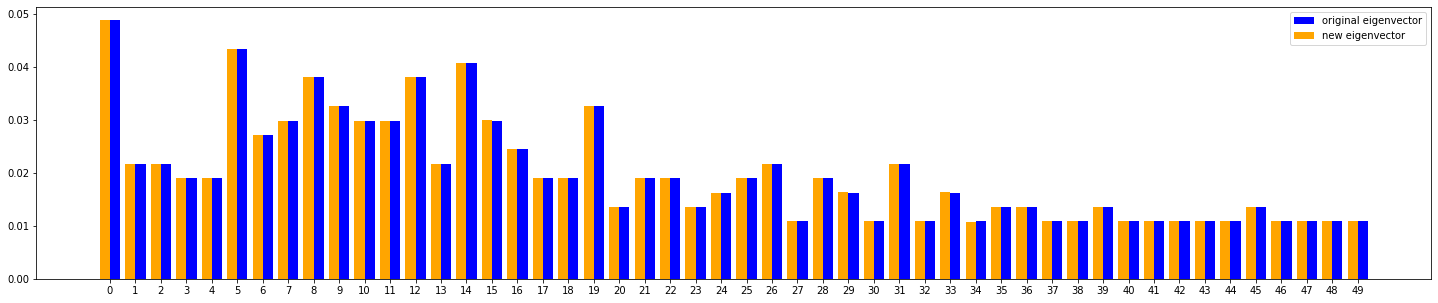

In [21]:
fig, ax = plt.subplots(figsize=(0.5*N, 5))

pSNorm = [h/sum(pS) for h in pS]
pSNorm_new = [abs(h)/sum(abs(pS_new)) for h in pS_new]
nodes = sorted([int(n) for n in G.nodes])

ax.bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax.bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

ax.set_xticks(np.arange(0, N, 1))
ax.legend()
plt.show()

In [22]:
for i in range(10):
    print(sum(P_new[i]))

2.1290349498215697
0.8434444756954405
0.8602669439255584
0.5557156190372848
0.5025284298171265
1.6305807884709274
0.9365147612065062
1.1624035671403412
1.7774635699879742
1.2036102588027264


In [23]:
walker_per_node = 200

In [24]:
seed = np.random.RandomState()
def dynamic_evolution(G, P_new, history = []):
    evolution = [0] * N
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neightbours = []
            n = int(n)
            for ind in range(len(P_new[n])):
                if P_new[n][ind] != 0:
                    if len(neightbours) != 0:
                        neightbours += [[ind, P_new[n][ind] + neightbours[-1][1]]]
                    else:
                        neightbours += [[ind, P_new[n][ind]]]
            s = sum(P_new[n])
            prob = rd.uniform(0., s)

            for neigh, p in neightbours:
                if prob <= p:
                    evolution[neigh] += 1
                    break
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[int(n)]
    history += [evolution]

In [25]:
history = [[], [], []]
for h in range(len(history)):
    history[h] = [[walker_per_node] * len(G.nodes)]

In [26]:
time_steps = int(5e1)

In [27]:
t0 = time.time()

for h in range(len(history)):
    h = int(h)
    for n in G.nodes:
        G.nodes[n]['N_i'] = walker_per_node
    
    for t in range(time_steps):
#         t1 = time.time()
        dynamic_evolution(G, P_new, history[h])
#         print(f"done in {int((time.time()-t1)/60)} minutes and {((time.time()-t1)%60)} seconds")

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 0 minutes and 25.117719411849976 seconds


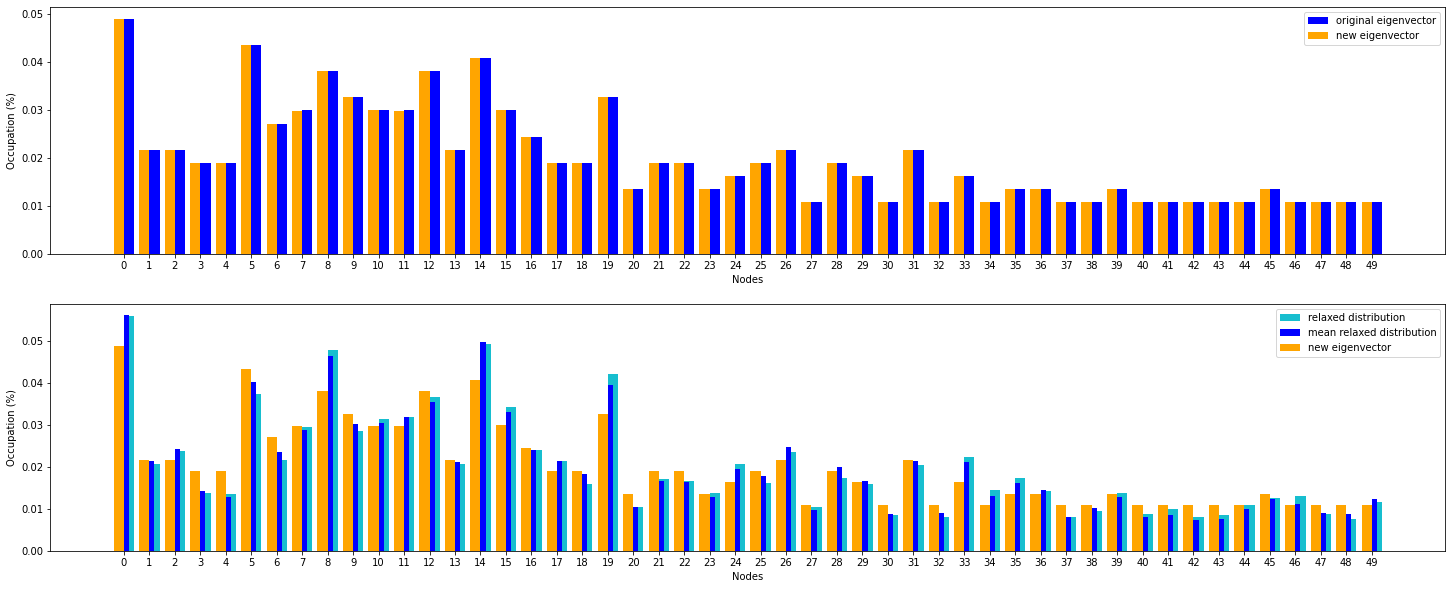

Solution found minimizing 50 equation in 183 variables


In [28]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(0.5*N, 10))

pSNorm = [h/sum(pS) for h in pS]
pSNorm_new = [h/sum(abs(pS_new)) for h in pS_new]
nodes = sorted([int(n) for n in G.nodes])

ax[0].bar(nodes, pSNorm, width=0.4, align='edge', color='blue', label="original eigenvector")
ax[0].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

hMean = [[(h1+h2+h3)/walker_per_node/N/3 
          for h1, h2, h3 in zip(history[0][i], history[1][i], history[2][i])] 
         for i in range(len(history[0]))]

ax[1].bar(nodes, [h/sum(history[0][-1]) for h in history[0][-1]], width=0.4, 
          align='edge', color='tab:cyan', label='relaxed distribution')
ax[1].bar(nodes, hMean[-1], width=0.2, align='edge', color='blue', label='mean relaxed distribution')
ax[1].bar(nodes, pSNorm_new, width=-0.4, align='edge', color='orange', label="new eigenvector")

for i in [0,1]:
    ax[i].legend()
    ax[i].set_xlabel("Nodes")
    ax[i].set_ylabel("Occupation (%)")
    ax[i].set_xticks(np.arange(0, N, 1))
#     ax[i].grid(True)

plt.show()

print(f"Solution found minimizing {N} equation in {links} variables")

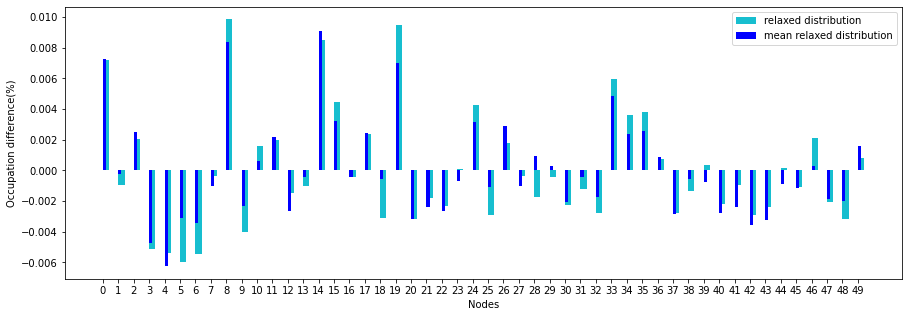

0.0024482363345657183


In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(0.3*N, 5))

ax.bar(nodes, [h/sum(history[0][-1]) - k for h, k in zip(history[0][-1], pSNorm_new)], width=0.4, 
       align='edge', color='tab:cyan', label='relaxed distribution')
ax.bar(nodes, [h - k for h, k in zip(hMean[-1], pSNorm_new)],
       width=0.2, align='edge', color='blue', label='mean relaxed distribution')

ax.legend()
ax.set_xlabel("Nodes")
ax.set_ylabel("Occupation difference(%)")
ax.set_xticks(np.arange(0, N, 1))
# ax.grid(True)

plt.show()

print(sum([np.abs(h - k) for h, k in zip(hMean[-1], pSNorm_new)])/len(history[0]))

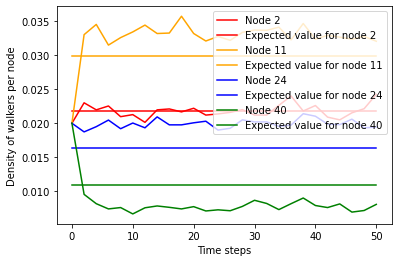

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
node = [2, 11, 24, 40]
col = ['red', 'orange', 'blue', 'green']

time_range = hMean
index = np.arange(0, len(time_range), 2)

j=0
for i in node:
    ax.plot(index, [time_range[ind][i] for ind in index], label = f"Node {i}", color = col[j])
    ax.plot(index, [pSNorm_new[i]]*len(index), label = f"Expected value for node {i}", color = col[j])
    j += 1
    
ax.set_xlabel("Time steps")
ax.set_ylabel("Density of walkers per node")
ax.legend()

plt.show()